In [3]:
import os
import sys
import logging
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, Any, List, Generator

In [4]:
# package imports
from vsim import electorate, candidates, simulation, voting_system

# Analysing proportional voting systems

We'll be using the case study of the Swedish parlimentary election systems, namely that there exists n-parties, voters vote for the preferred option (using the distance method we described earlier). The difference is the "winner" is not as well defined. 

In [12]:
# setup helper for generating experiments (basically all sets of params to run through sim)
def generate_experiment_matrix(experiments: Dict[str, List[Any]]):
    return (dict(zip(experiments, x)) for x in itertools.product(*experiments.values()))

experiments = {
    "electorate_size": [10_000, 25_000, 50_000],
    "clusters": [1, 2, 5, 10],
    "cluster_std": [1, 2, 3],
    "electoral_system": ["proportional"],
    "apathy_prob": [0.0, 0.01, 0.05],
    "candidates": [2, 4, 5, 9], # akin to parties in the proportional case
    "issues": [2, 5, 10, 25],
    "seats": [150, 179, 349, 736], # dutch, danish, swedish, german parliment(s) seats
    "min_share_threshold": [0, 0.04, 0.10] # dutch, swedish, and turkish thresholds
}
records = []
columns = [*experiments.keys(), "unweighted_fairness", "weighted_fairness"]
experiment_matrix = list(generate_experiment_matrix(experiments))

for params in tqdm(experiment_matrix):

    # setup objects
    voters = electorate.setup_electorate(**params)
    parties = candidates.setup_candidates(**params, electorate=voters)
    system = voting_system.setup_voting_system(name=params["electoral_system"], **params)

    # simulate elections
    sim = simulation.VotingSimulator(electorate=voters, candidates=parties, system=system, log=logging.getLogger())

    result = sim.run()
    result_record = { 
        "unweighted_fairness": round(result.unweighted_fairness, 3),
        "weighted_fairness": round(result.weighted_fairness, 3),
        **params 
    }
    result_record = {k: v for k, v in result_record.items() if k in columns}
    records.append(result_record)

100%|██████████████████████████████████████| 20736/20736 [1:04:29<00:00,  5.36it/s]


In [2]:
results_df = pd.DataFrame.from_records(records)
results_df

NameError: name 'pd' is not defined

In [5]:
filepath = "data/proportional-vs-proportional-df5ec973-c180-40ef-a410-1490716cd4e2.csv"
assert not os.path.isfile(filepath), "file already exists; use a new uuid to avoid overwriting"
results_df.to_csv(filepath, index=False)

AssertionError: file already exists; use a new uuid to avoid overwriting

In [6]:
results_df = pd.read_csv(filepath)

**NOTE:** that unweighted fairness does not have any meaning in the proportional case and should not be used to compare between majority/plurality and proportionality electoral systems.

### Investigating factors of fairness

In [7]:
corr_df = results_df.drop(["electoral_system", "unweighted_fairness"], axis=1).corrwith(results_df.weighted_fairness)

In [8]:
df = pd.DataFrame(corr_df).drop("weighted_fairness", axis=0)
df.index = df.index.rename("measure")
df.columns = ["weighted_fairness"]
df = df.reset_index()

In [9]:
df

,measure,weighted_fairness
0,electorate_size,-0.001871
1,clusters,-0.502127
2,cluster_std,-0.254411
3,apathy_prob,0.001108
4,candidates,-0.036729
5,issues,0.045120
6,seats,-0.000267
7,min_share_threshold,0.000151


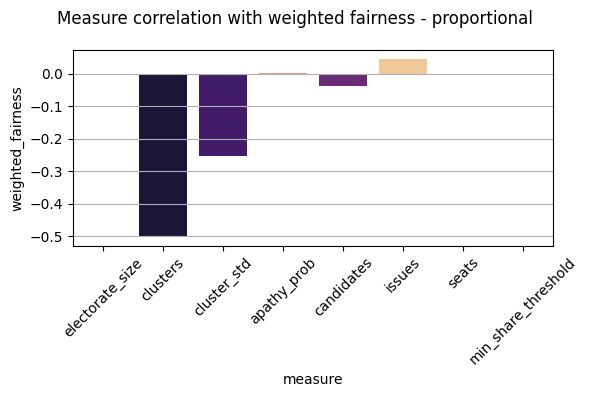

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
sns.barplot(data=df.reset_index(), x="measure", y="weighted_fairness", hue="weighted_fairness", palette="magma", ax=ax, dodge=False)
ax.get_legend().set_visible(False)
ax.grid(axis="y")
plt.suptitle("Measure correlation with weighted fairness - proportional")
plt.xticks(rotation=45)
plt.show()

# Factor analysis via OLS

In [13]:
import statsmodels.api as sm

target = "weighted_fairness"
superflous_cols = ["weighted_fairness", "unweighted_fairness", "electoral_system"]
features = [c for c in results_df.columns if c not in superflous_cols]

# setup and get results
ols = sm.OLS(endog=results_df[target], exog=results_df[features]).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      weighted_fairness   R-squared (uncentered):                   0.591
Model:                            OLS   Adj. R-squared (uncentered):              0.591
Method:                 Least Squares   F-statistic:                              3742.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                        0.00
Time:                        12:53:50   Log-Likelihood:                         -34146.
No. Observations:               20736   AIC:                                  6.831e+04
Df Residuals:                   20728   BIC:                                  6.837e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
electorate_size       1.52e-05   4.91e-07     30.976      0.000    1.42e-05    1.62e-05
clusters               -0.1295      0.002    -54.112      0.000      -0.134      -0.125
cluster_std             0.0434      0.009      4.791      0.000       0.026       0.061
apathy_prob             6.3839      0.396     16.139      0.000       5.609       7.159
candidates              0.0950      0.003     30.664      0.000       0.089       0.101
issues                  0.0263      0.001     27.615      0.000       0.024       0.028
seats                   0.0010   3.53e-05     27.040      0.000       0.001       0.001
min_share_threshold     4.0783      0.206     19.825      0.000       3.675       4.482
==============================================================================
Omnibus:                     6998.949   Durbin-Watson:                   0.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22821.480
Skew:                           1.738   Prob(JB):                         0.00
Kurtosis:                       6.786   Cond. No.                     1.49e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.49e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""